Import Libraries.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

Load Data.

In [2]:
data = pd.read_csv('diabetes.csv')
print(data)

     AGE   SEX   BMI      BP   S1     S2    S3    S4      S5   S6    Y
0     59     2  32.1  101.00  157   93.2  38.0  4.00  4.8598   87  151
1     48     1  21.6   87.00  183  103.2  70.0  3.00  3.8918   69   75
2     72     2  30.5   93.00  156   93.6  41.0  4.00  4.6728   85  141
3     24     1  25.3   84.00  198  131.4  40.0  5.00  4.8903   89  206
4     50     1  23.0  101.00  192  125.4  52.0  4.00  4.2905   80  135
..   ...   ...   ...     ...  ...    ...   ...   ...     ...  ...  ...
437   60     2  28.2  112.00  185  113.8  42.0  4.00  4.9836   93  178
438   47     2  24.9   75.00  225  166.0  42.0  5.00  4.4427  102  104
439   60     2  24.9   99.67  162  106.6  43.0  3.77  4.1271   95  132
440   36     1  30.0   95.00  201  125.2  42.0  4.79  5.1299   85  220
441   36     1  19.6   71.00  250  133.2  97.0  3.00  4.5951   92   57

[442 rows x 11 columns]


Separate features and target variable.

In [3]:
# All but the last column: age, sex, BMI, average BP, and six blood serum measurements
features = data.iloc[:, :-1].to_numpy()  
feature_names = data.columns[:-1].to_numpy()
n_samples, n_features = features.shape

# The last column: quantitative measure of disease progression one year after baseline
target = data.iloc[:, -1].to_numpy()  
target_name = data.columns[-1]

Define the training and testing set.

In [4]:
# Define how much training data we will use. The rest will be testing data.
train_frac = 0.9
# True if first 90% of data if train_frac=0.9, False otherwise
train_mask = np.linspace(0, 1, n_samples) < train_frac 

X_train = features[train_mask]
y_train = target[train_mask]
X_test = features[~train_mask]
y_test = target[~train_mask]

First, estimate the disease progression outcome using a single input variable (one-dimensional feature). Then, use the input variable that has the best Pearson correlation ceofficient to the target variable.

In [5]:
r = np.zeros((n_features,))
for i in range(n_features):
    r[i] = pearsonr(X_train[:, i], y_train)[0]
# Does not matter if the best feature is positively or negatively correlated, so take the absolute value
r = np.absolute(r)  

# Identify feature with the best correlation
best_feature_idx = np.argmax(r) 
best_feature = X_train[:, [best_feature_idx]] 

Plot the best feature.

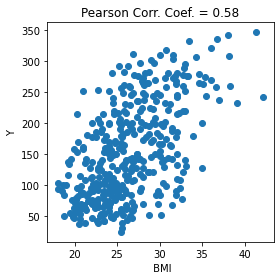

In [6]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(best_feature, y_train)
ax.set_xlabel(feature_names[best_feature_idx])
ax.set_ylabel(target_name)
ax.set_title('Pearson Corr. Coef. = {:.2f}'.format(r[best_feature_idx]))
fig.tight_layout()

Performing a linear fitting between the selected feature and the target variable, which is equivalent to 1D regression. 

In [10]:
model = LinearRegression().fit(best_feature, y_train)
intercept = model.intercept_  # offset (intercept) for 1D line fitting
slope = model.coef_[0]  # slope of the line

Visualize the model.

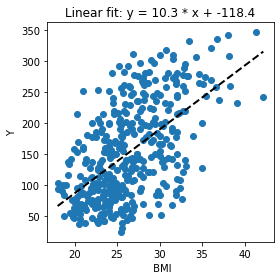

In [11]:
# Creating 100 points line space between the minimum & maximum values of the selected feature
x = np.linspace(best_feature.min(), best_feature.max(), 100)
y = slope * x + intercept

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(best_feature, y_train)
ax.plot(x, y, linestyle='--', color='k', linewidth=2)
ax.set_xlabel(feature_names[best_feature_idx])
ax.set_ylabel(target_name)
ax.set_title('Linear fit: y = {:.1f} * x + {:.1f}'.format(slope, intercept))
fig.tight_layout()

With this trained model, make predictions on the testing dataset.
Because it is known that the "actual" measure of the disease progression of the testing set, compare the estimates with the actual values. 

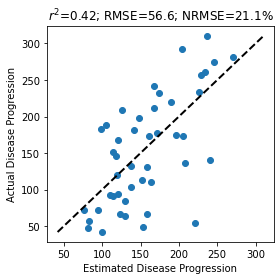

In [10]:
y_hat = model.predict(X_test[:, [best_feature_idx]])
# coefficient of determination
r2 = r2_score(y_test, y_hat) 
# root mean square error (unit: mg/L)
rmse = np.sqrt(np.mean(np.square(y_test - y_hat)))  
# RMSE normalized to the value range of the target variable (unit: %)
nrmse = rmse / np.ptp(y_test)  

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_hat, y_test)
min_, max_ = min(y_hat.min(), y_test.min()), max(y_hat.max(), y_test.max())
# Perfect estimation line
x = np.linspace(min_, max_, 100)  
ax.plot(x, x, linestyle='--', color='k', linewidth=2)
ax.set_xlabel('Estimated Disease Progression')
ax.set_ylabel('Actual Disease Progression')
ax.set_title('$r^2$={:.2f}; RMSE={:.1f}; NRMSE={:.1f}%'.format(r2, rmse, nrmse * 100))
fig.tight_layout()